  # scXpand Tutorial: Data Preparation and Model Application







  This tutorial demonstrates how to prepare scRNA-seq data and apply scXpand models for T cell expansion prediction.







  ## Example Dataset







  We use a publicly available scRNA-seq dataset of breast cancer patients from:



  - **Study**: Tietscher et al. 2023 (E-MTAB-10607)



  - **Source**: https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-10607/



  - **Data type**: scRNA-seq only (no paired scTCR-seq)



  - **Cancer type**: Breast cancer



  - **Tissue**: Tumor samples







  ## Tutorial Structure







  - **Data Loading and Initial Processing**



  - **Quality Control and Filtering**



  - **Data Preparation for scXpand**



  - **Model Application and Inference**



  - **Robustness Testing**

  ---



  ## Data Loading and Initial Processing

In [1]:
import sys

from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from scipy import sparse


# Plotting settings
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.axisbelow"] = True

# Setup project paths
project_root = Path.cwd().parent
print(f"Project root: {project_root}")
sys.path.insert(0, str(project_root))

Project root: /Users/rona/my_repos/scxpand


  ### Discover and Validate Data Files

In [ ]:
# Setup data paths
demo_path = project_root / "data/demo"
source_path = demo_path / "E-MTAB-10607_BC"
# Please make sure to download the data from https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-10607/ and place it in the source_path directory

# Collect matrix and metadata files
mtx_files = sorted(source_path.glob("*_matrix.txt"))
metadata_files = sorted(source_path.glob("*_metadata.txt"))

# Extract sample IDs from matrix file prefixes
sample_ids = [file.stem.split("_")[0] for file in mtx_files]

# Validate file consistency
assert len(sample_ids) == len(metadata_files) == len(mtx_files), "Mismatch in file counts"
assert all(sample_id in metadata_files[i].stem for i, sample_id in enumerate(sample_ids)), (
    "Sample ID mismatch in metadata files"
)
assert all(sample_id in mtx_files[i].stem for i, sample_id in enumerate(sample_ids)), (
    "Sample ID mismatch in matrix files"
)

n_samples = len(mtx_files)
print(f"Found {n_samples} samples to process")

Found 14 samples to process


  ### Load and Concatenate Sample Data

In [3]:
def load_sample_data(sample_idx: int, sample_id: str, mtx_file: Path, metadata_file: Path) -> ad.AnnData:
    """Load and process a single sample's data."""
    print(f"Loading sample {sample_idx + 1} of {n_samples}: {sample_id}")

    # Load expression matrix and transpose
    sample_data = sc.read_text(mtx_file).transpose()

    # Create clean cell names (remove suffix after dot)
    sample_data.obs_names = sample_id + "_" + sample_data.obs_names.to_series().str.split(".").str[0]

    # Convert to sparse matrix for memory efficiency
    sample_data.X = sparse.csr_matrix(sample_data.X)

    # Load and merge metadata
    metadata = pd.read_csv(metadata_file, sep="\t", index_col=0)
    for col in metadata.columns:
        sample_data.obs[col] = metadata[col]

    return sample_data


# Load samples with progress tracking
print("Loading all samples...")
adata_list = []
for i, (sample_id, mtx_file, metadata_file) in enumerate(zip(sample_ids, mtx_files, metadata_files)):
    sample_adata = load_sample_data(i, sample_id, mtx_file, metadata_file)
    adata_list.append(sample_adata)

# Concatenate all samples
adata = ad.concat(adata_list)
del adata_list  # Free memory

# Make a copy to avoid view modification warnings
adata = adata.copy()

Loading all samples...
Loading sample 1 of 14: TBB011
Loading sample 2 of 14: TBB035
Loading sample 3 of 14: TBB075
Loading sample 4 of 14: TBB102
Loading sample 5 of 14: TBB111
Loading sample 6 of 14: TBB129
Loading sample 7 of 14: TBB165
Loading sample 8 of 14: TBB171
Loading sample 9 of 14: TBB184
Loading sample 10 of 14: TBB212
Loading sample 11 of 14: TBB214
Loading sample 12 of 14: TBB226
Loading sample 13 of 14: TBB330
Loading sample 14 of 14: TBB338


In [4]:
print(f"Combined dataset shape: {adata.shape}")
print(f"Data type: {type(adata.X)}")

Combined dataset shape: (159498, 21959)
Data type: <class 'scipy.sparse._csr.csr_matrix'>


  ---



  ## Quality Control and Filtering

  ### Mitochondrial Gene Analysis

In [5]:
# Display all mitochondrial genes in dataset (37 genes total)
mt_genes_in_data = adata.var[adata.var_names.str.startswith("MT-")].index
print(f"Found {len(mt_genes_in_data)} mitochondrial genes in dataset:")
print(mt_genes_in_data.tolist())

Found 37 mitochondrial genes in dataset:
['MT-TF', 'MT-RNR1', 'MT-TV', 'MT-RNR2', 'MT-TL1', 'MT-ND1', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-ND2', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-CO1', 'MT-TS1', 'MT-TD', 'MT-CO2', 'MT-TK', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-TG', 'MT-ND3', 'MT-TR', 'MT-ND4L', 'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE', 'MT-CYB', 'MT-TT', 'MT-TP']


In [6]:
# We will use only the 13 protein-coding mitochondrial genes for QC
# (to be consistent with other datasets having just these genes)
mt_genes = [
    "MT-ND1",
    "MT-ND2",
    "MT-CO1",
    "MT-CO2",
    "MT-ATP8",
    "MT-ATP6",
    "MT-CO3",
    "MT-ND3",
    "MT-ND4L",
    "MT-ND4",
    "MT-ND5",
    "MT-ND6",
    "MT-CYB",
]

# Mark protein-coding mitochondrial genes for QC
adata.var["mt"] = adata.var_names.isin(mt_genes)
print(f"Using {adata.var['mt'].sum()} protein-coding MT genes for QC")

# Calculate QC metrics for each cell
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

Using 13 protein-coding MT genes for QC


  ### Quality Control Visualization and Filtering

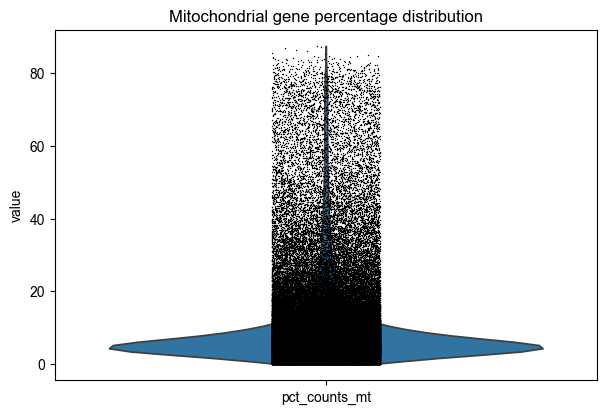

In [7]:
# Visualize mitochondrial gene percentage distribution
ax = sc.pl.violin(adata, "pct_counts_mt", jitter=0.1, show=False)
ax.set_title("Mitochondrial gene percentage distribution")
plt.show()

In [8]:
# Apply quality control filters
print(f"Before filtering: {adata.n_obs} cells, {adata.n_vars} genes")

# Filter cells with high mitochondrial content (< 10%)
adata = adata[adata.obs.pct_counts_mt < 10, :]

# Filter low-quality cells and genes
sc.pp.filter_cells(adata, min_genes=200)  # Remove cells with < 200 genes
sc.pp.filter_genes(adata, min_cells=3)  # Remove genes in < 3 cells

print(f"After filtering: {adata.n_obs} cells, {adata.n_vars} genes")
print(f"Final data shape: {adata.shape}")

Before filtering: 159498 cells, 21959 genes


/Users/rona/my_repos/scxpand/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


After filtering: 119704 cells, 19754 genes
Final data shape: (119704, 19754)


  ### Doublet Detection
  - Simulates doublets by combining random cell pairs
  - Computes doublet scores for all cells
  - Provides automatic threshold detection
  - Processes samples separately to account for batch effects


In [9]:
# Run Scrublet doublet detection
sc.pp.scrublet(
    adata,
    expected_doublet_rate=0.05,  # Expected doublet rate for the dataset
    batch_key="sample",  # Process each sample separately
    random_state=42,  # For reproducibility
)

#   Original code used in our dataset generation (replaced with scanpy's implementation out due to compatibility issues):
#  import scrublet as scr
#  scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.05)
#  adata.obs["doublet_scores"], adata.obs["predicted_doublets"] = scrub.scrub_doublets()

In [10]:
# Plot histogram of doublet scores (optional)
# sc.pl.scrublet_score_distribution(adata)

In [11]:
# Filter out cells with high doublet score using a conservative threshold
doublet_threshold = 0.3
adata = adata[
    adata.obs["doublet_score"] < doublet_threshold
]  # Note: column name is "doublet_score" not "doublet_scores"
print(f"Filtered out cells with doublet scores >= {doublet_threshold}")
print(f"Remaining cells after doublet filtering: {adata.n_obs}")

Filtered out cells with doublet scores >= 0.3
Remaining cells after doublet filtering: 118631


In [12]:
# Verify doublet filtering results
print("Predicted doublet status:")
print(adata.obs["predicted_doublet"].value_counts())
print(f"Max doublet score after filtering: {adata.obs['doublet_score'].max():.3f}")

# filter remaining doublets based on predicted_doublet column:
adata = adata[~adata.obs["predicted_doublet"], :]
print(f"Remaining cells after removing predicted doublets: {adata.n_obs}")

Predicted doublet status:
predicted_doublet
False    118517
True        114
Name: count, dtype: int64
Max doublet score after filtering: 0.299
Remaining cells after removing predicted doublets: 118517


In [13]:
# save raw count matrix:
adata.layers["counts"] = adata.X.copy()

/var/folders/kc/qpbjrjdx2zs_tg13rp6kmnk00000gn/T/ipykernel_46829/3004074460.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [14]:
# add some metadata information for our records:
adata.obs["cancer_type"] = "BC"
adata.obs["study"] = "Tietscher et al. 2023 (BC)"
adata.obs["tissue_type"] = "Tumor"

# apply this because of file-writing error in this specific dataset:
adata.obs["excl_doublet"] = adata.obs["excl_doublet"].astype(str)
adata.obs["excl_QC"] = adata.obs["excl_QC"].astype(str)

  ---



  ## Data Preparation for scXpand

  ### T Cell Filtering







  The scXpand model is specifically designed for T cells. We need to filter our dataset



  to include only T cells before applying the model.







  **Note:** This step can be done using:



  - Your own clustering solution



  - Cell type annotation tools



  - Imputation methods (e.g., MAGIC)



  - Pre-existing cell annotations (as in this example)

In [15]:
# Filter for T cells only (removing NK cells) according to cell metadata from authors
# The model input will include only T cells (we kept NKT cells as well)
print(f"Before T cell filtering: {adata.n_obs} cells")

t_cell_mask = (~adata.obs["Tcell_metacluster"].replace("none", np.nan).isna()) & (
    ~adata.obs["Tcell_metacluster"].isin(["NK", "NK_activated"])
)
adata = adata[t_cell_mask]
print(f"After T cell filtering: {adata.n_obs} cells remaining")

Before T cell filtering: 118517 cells
After T cell filtering: 26596 cells remaining


  ### Gene ID Conversion







  **Important:** The scXpand model requires Ensembl gene IDs as gene identifiers.







  - **If your data already has Ensembl IDs:** Simply set them as `var_names` and the model will handle missing genes automatically



  - **If your data uses gene symbols:** Follow the conversion process below

In [16]:
# Load the gene list we want to keep (authors provided genes without ensembl_ids)
# This file can be found in our Figshare publicly available repository: https://doi.org/10.6084/m9.figshare.30067666
gene_table_path = demo_path / "gene_table_for_scXpand.csv.gz"
gene_table = pd.read_csv(gene_table_path, index_col=1)
print(f"Loaded gene table with {len(gene_table)} genes")
print("Gene table columns:", gene_table.columns.tolist())

Loaded gene table with 11950 genes
Gene table columns: ['gene_ids', 'feature_types']


In [17]:
# Filter gene table to include only genes present in the dataset
# Note: If genes were missing, the model would handle this by setting expression to zero
gene_table = gene_table[gene_table.index.to_series().isin(adata.var.index)]
print(f"Gene table after filtering: {len(gene_table)} genes")
print(f"All genes present in dataset: {len(gene_table) == len(adata.var)}")

Gene table after filtering: 11950 genes
All genes present in dataset: False


In [18]:
# Subset adata to include only genes in the gene table
adata = adata[:, gene_table.index]
print(f"Data after gene filtering: {adata.shape}")

# Add gene IDs and feature types to adata.var
adata.var["gene_ids"] = gene_table["gene_ids"]
adata.var["feature_types"] = gene_table["feature_types"]

Data after gene filtering: (26596, 11950)


/var/folders/kc/qpbjrjdx2zs_tg13rp6kmnk00000gn/T/ipykernel_46829/112391731.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_ids"] = gene_table["gene_ids"]


In [19]:
# Convert gene names to Ensembl IDs (required by scXpand model)
# The model requires Ensembl IDs as var_names (index)
adata.var = adata.var.rename_axis("gene_name").reset_index().set_index("gene_ids")

print("Gene identifiers successfully converted to Ensembl IDs")
print(f"Example gene IDs: {adata.var.index[:5].tolist()}")

Gene identifiers successfully converted to Ensembl IDs
Example gene IDs: ['ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000188290', 'ENSG00000187608']


  ### Save Processed Data (Optional)

In [20]:
# Save the processed data for future use (optional)
# output_path = project_root / "data/processed/scXpand_count_data_T_cells_E-MTAB-10607.h5ad"
# adata.write(output_path, compression='gzip')
# print(f"Processed data saved to: {output_path}")
print("Data preprocessing completed - ready for model application!")

Data preprocessing completed - ready for model application!


  ---



## T  Cell Expansion Prediction with Pre-trained Models

  ### Setup Model and Device

In [21]:
from scxpand.util.general_util import get_device


# Setup device and plotting style
device = get_device()
print(f"Using device: {device}")
sns.set_style("whitegrid")

Using device: mps


  ### Configure Model and Data

In [22]:
# Model configuration
model_name = "pan_cancer_logistic"  # Choose from available pretrained models

# Data configuration - we'll use the processed data from the demo
adata_path = demo_path / "scXpand_count_data_T_cells_E-MTAB-10607.h5ad"
adata_demo = sc.read_h5ad(adata_path)  # Load preprocessed data

# Inference parameters
batch_size = 2048
num_workers = 4
save_path = project_root / f"results/inference_results/{model_name}_inference"

print(f"Selected model: {model_name}")
print(f"Demo data: {adata_demo.n_obs} cells, {adata_demo.n_vars} genes")
print(f"Results will be saved to: {save_path}")

# Create output directory
save_path.mkdir(parents=True, exist_ok=True)

Selected model: pan_cancer_logistic
Demo data: 26597 cells, 11950 genes
Results will be saved to: /Users/rona/my_repos/scxpand/results/inference_results/pan_cancer_logistic_inference


  ### Run Inference

In [23]:
# Run inference on the demo dataset

from scxpand import run_inference


print(f"Running inference with {model_name} model...")

results = run_inference(
    adata=adata_demo,
    model_name=model_name,
    batch_size=batch_size,
    num_workers=num_workers,
    device=device,
)
y_pred_prob = results.predictions

print("Inference completed successfully!")
print(f"Example predictions (probabilities): {y_pred_prob[:5]}")
print(f"Prediction shape: {y_pred_prob.shape}")

Running inference with pan_cancer_logistic model...
2025-09-10 18:22:54 [info     ] Using registry model: pan_cancer_logistic [scxpand.core.inference]
2025-09-10 18:22:54 [info     ] Using registry model: pan_cancer_logistic [scxpand.pretrained.inference_api]
2025-09-10 18:22:54 [info     ] Model version: 1.0.0           [scxpand.pretrained.inference_api]
2025-09-10 18:22:54 [info     ] Model type will be auto-detected from model_type.txt [scxpand.pretrained.inference_api]
2025-09-10 18:22:54 [info     ] Using cache directory: /Users/rona/my_repos/scxpand/notebooks/.scxpand_cache [scxpand.pretrained.download_manager]
2025-09-10 18:22:54 [info     ] Downloading registry model 'pan_cancer_logistic' from: https://figshare.com/ndownloader/articles/30067666/versions/1?folder_path=logistic [scxpand.pretrained.download_manager]


100%|████████████████████████████████████████| 426k/426k [00:00<00:00, 627MB/s]
SHA256 hash of downloaded file: 3a33e1a00248f639a5d88134c018e32d0a3fecf9b3d090423a30f16f26b3cebe
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
Unzipping contents of '/Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/5be9d6a5c323e8814ceae709733c7003-1' to '/Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/5be9d6a5c323e8814ceae709733c7003-1.unzip'


2025-09-10 18:22:55 [info     ] Normalizing filename: 57702358_model_type.txt -> model_type.txt [scxpand.pretrained.download_manager]
2025-09-10 18:22:55 [info     ] Normalizing filename: 57702361_parameters.json -> parameters.json [scxpand.pretrained.download_manager]
2025-09-10 18:22:55 [info     ] Normalizing filename: 57702349_data_format.json -> data_format.json [scxpand.pretrained.download_manager]
2025-09-10 18:22:55 [info     ] Normalizing filename: 57702352_data_format.npz -> data_format.npz [scxpand.pretrained.download_manager]
2025-09-10 18:22:55 [info     ] Normalizing filename: 57702355_model.joblib -> model.joblib [scxpand.pretrained.download_manager]
2025-09-10 18:22:55 [info     ] Model successfully downloaded and cached at: /Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/5be9d6a5c323e8814ceae709733c7003-1.unzip/logistic [scxpand.pretrained.download_manager]
2025-09-10 18:22:55 [info     ] Running inference with batch size: 2048 [scxpand.pretrained.inference_api]


  ---



  ## Robustness Testing

  ### Gene Order Independence Test







  The scXpand model is designed to be robust to gene ordering. Let's verify this



  by shuffling the genes and confirming identical predictions.

In [24]:
# Shuffle genes to demonstrate gene-order independence
print("Testing gene-order independence...")
shuffled_var = adata_demo.var.sample(frac=1, random_state=42)

results = run_inference(
    model_name=model_name,
    adata=adata_demo[:, shuffled_var.index],
    device=device,
    batch_size=batch_size,
    num_workers=num_workers,
)
y_pred_prob_shuffled = results.predictions

print("Inference with shuffled genes completed!")
print(f"Example predictions (probabilities): {y_pred_prob_shuffled[:5]}")

# Verify predictions are identical (gene order doesn't matter)
predictions_match = np.allclose(y_pred_prob, y_pred_prob_shuffled)
print(f"Predictions identical with shuffled genes: {predictions_match}")

Testing gene-order independence...
2025-09-10 18:23:06 [info     ] Using registry model: pan_cancer_logistic [scxpand.core.inference]
2025-09-10 18:23:06 [info     ] Using registry model: pan_cancer_logistic [scxpand.pretrained.inference_api]
2025-09-10 18:23:06 [info     ] Model version: 1.0.0           [scxpand.pretrained.inference_api]
2025-09-10 18:23:06 [info     ] Model type will be auto-detected from model_type.txt [scxpand.pretrained.inference_api]
2025-09-10 18:23:06 [info     ] Using cache directory: /Users/rona/my_repos/scxpand/notebooks/.scxpand_cache [scxpand.pretrained.download_manager]
2025-09-10 18:23:06 [info     ] Downloading registry model 'pan_cancer_logistic' from: https://figshare.com/ndownloader/articles/30067666/versions/1?folder_path=logistic [scxpand.pretrained.download_manager]


Unzipping contents of '/Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/5be9d6a5c323e8814ceae709733c7003-1' to '/Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/5be9d6a5c323e8814ceae709733c7003-1.unzip'


2025-09-10 18:23:06 [info     ] Normalizing filename: 57702358_model_type.txt -> model_type.txt [scxpand.pretrained.download_manager]
2025-09-10 18:23:06 [info     ] Normalizing filename: 57702361_parameters.json -> parameters.json [scxpand.pretrained.download_manager]
2025-09-10 18:23:06 [info     ] Normalizing filename: 57702349_data_format.json -> data_format.json [scxpand.pretrained.download_manager]
2025-09-10 18:23:06 [info     ] Normalizing filename: 57702352_data_format.npz -> data_format.npz [scxpand.pretrained.download_manager]
2025-09-10 18:23:06 [info     ] Normalizing filename: 57702355_model.joblib -> model.joblib [scxpand.pretrained.download_manager]
2025-09-10 18:23:06 [info     ] Model successfully downloaded and cached at: /Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/5be9d6a5c323e8814ceae709733c7003-1.unzip/logistic [scxpand.pretrained.download_manager]
2025-09-10 18:23:06 [info     ] Running inference with batch size: 2048 [scxpand.pretrained.inference_api]


  ### Missing Gene Handling Test







  The model automatically handles missing genes by setting their expression to zero,



  mimicking sequencing dropouts. Let's test this by removing some genes.

In [25]:
# Remove last 50 genes to demonstrate missing gene handling
print("Testing missing gene handling...")
n_genes_to_remove = 50
adata_subset = adata_demo[:, :-n_genes_to_remove]
print(f"Removed {n_genes_to_remove} genes: {adata_subset.n_vars} genes remaining")

results = run_inference(
    model_name=model_name,
    adata=adata_subset,
    device=device,
    batch_size=batch_size,
    num_workers=num_workers,
)
y_pred_prob_missing = results.predictions

print("Inference with missing genes completed!")
print(f"Example predictions (probabilities): {y_pred_prob_missing[:5]}")

# Compare predictions with and without missing genes
print("\nPrediction comparison:")
print(f"Original predictions mean: {y_pred_prob.mean():.4f}")
print(f"Missing genes predictions mean: {y_pred_prob_missing.mean():.4f}")
print("Model successfully handled missing genes!")

Testing missing gene handling...
Removed 50 genes: 11900 genes remaining
2025-09-10 18:23:17 [info     ] Using registry model: pan_cancer_logistic [scxpand.core.inference]
2025-09-10 18:23:17 [info     ] Using registry model: pan_cancer_logistic [scxpand.pretrained.inference_api]
2025-09-10 18:23:17 [info     ] Model version: 1.0.0           [scxpand.pretrained.inference_api]
2025-09-10 18:23:17 [info     ] Model type will be auto-detected from model_type.txt [scxpand.pretrained.inference_api]
2025-09-10 18:23:17 [info     ] Using cache directory: /Users/rona/my_repos/scxpand/notebooks/.scxpand_cache [scxpand.pretrained.download_manager]
2025-09-10 18:23:17 [info     ] Downloading registry model 'pan_cancer_logistic' from: https://figshare.com/ndownloader/articles/30067666/versions/1?folder_path=logistic [scxpand.pretrained.download_manager]


Unzipping contents of '/Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/5be9d6a5c323e8814ceae709733c7003-1' to '/Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/5be9d6a5c323e8814ceae709733c7003-1.unzip'


2025-09-10 18:23:17 [info     ] Normalizing filename: 57702358_model_type.txt -> model_type.txt [scxpand.pretrained.download_manager]
2025-09-10 18:23:17 [info     ] Normalizing filename: 57702361_parameters.json -> parameters.json [scxpand.pretrained.download_manager]
2025-09-10 18:23:17 [info     ] Normalizing filename: 57702349_data_format.json -> data_format.json [scxpand.pretrained.download_manager]
2025-09-10 18:23:17 [info     ] Normalizing filename: 57702352_data_format.npz -> data_format.npz [scxpand.pretrained.download_manager]
2025-09-10 18:23:17 [info     ] Normalizing filename: 57702355_model.joblib -> model.joblib [scxpand.pretrained.download_manager]
2025-09-10 18:23:17 [info     ] Model successfully downloaded and cached at: /Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/5be9d6a5c323e8814ceae709733c7003-1.unzip/logistic [scxpand.pretrained.download_manager]
2025-09-10 18:23:17 [info     ] Running inference with batch size: 2048 [scxpand.pretrained.inference_api]


  ---



  ## Summary







  This tutorial demonstrated:







  1. **Data Loading**: How to load and combine multiple samples



  2. **Quality Control**: Mitochondrial gene filtering and doublet detection



  3. **Data Preparation**: T cell filtering and gene ID conversion



  4. **Model Application**: Running inference with pretrained scXpand models



  5. **Robustness Testing**: Gene order independence and missing gene handling







  The scXpand model is now ready to predict T cell expansion probabilities on your data!